In [24]:
!pip freeze > requirements.txt

In [106]:
import sklearn
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
# Load your cloud drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [123]:
# 讀入series
colnames=['Open','High','Low','Close'] 
df_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/training.csv', names=colnames)
date = pd.date_range(start='2015/01/01',periods=len(df_temp))
df = df_temp
date = pd.DataFrame(date)
df[['Date']] = date
#df.set_index('Date',inplace=True)
price = df.squeeze()
price.head()

,Open,High,Low,Close,Date
0,186.73,188.71,186.00,186.30,2015-01-01
1,185.57,186.33,184.94,185.54,2015-01-02
2,184.81,185.03,183.10,184.66,2015-01-03
3,184.39,184.48,182.31,182.54,2015-01-04
4,182.20,182.27,180.27,181.59,2015-01-05


In [124]:
# 讀入series
colnames=['Open','High','Low','Close'] 
df_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/testing.csv', names=colnames)
date2 = pd.date_range(start=date.iloc[len(date)-1,0],periods=2)
date2 = pd.DataFrame(date2)
date2 = pd.date_range(start=date2.iloc[len(date2)-1,0],periods=len(df_temp))
date2 = pd.DataFrame(date2)
df2 = df_temp
df2[['Date']] = date2
#df2.set_index('Date',inplace=True)
price2 = df2.squeeze()
price2.head()

,Open,High,Low,Close,Date
0,154.40,155.02,152.91,154.76,2019-01-28
1,155.96,156.80,155.07,156.46,2019-01-29
2,156.45,156.74,154.68,155.35,2019-01-30
3,154.10,156.22,154.09,154.10,2019-01-31
4,153.59,154.45,153.26,153.57,2019-02-01


In [125]:
df = pd.concat([df,df2])
df = df.reset_index()
df = df[['Open','High','Low','Close','Date']]
df

,Open,High,Low,Close,Date
0,186.73,188.71,186.00,186.30,2015-01-01
1,185.57,186.33,184.94,185.54,2015-01-02
2,184.81,185.03,183.10,184.66,2015-01-03
3,184.39,184.48,182.31,182.54,2015-01-04
4,182.20,182.27,180.27,181.59,2015-01-05
...,...,...,...,...,...
1503,151.82,153.00,151.50,152.50,2019-02-12
1504,152.51,153.86,152.50,152.83,2019-02-13
1505,152.95,153.18,152.61,153.13,2019-02-14
1506,153.20,154.12,153.20,154.04,2019-02-15


In [126]:
def relative_strength_idx(df, n=14):
    Open = df['Open']
    delta = Open.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# SMA
df['EMA_5'] = df['Open'].ewm(5).mean().shift()
df['EMA_10'] = df['Open'].ewm(10).mean().shift()
df['EMA_20'] = df['Open'].ewm(20).mean().shift()

# EMA
df['SMA_5'] = df['Open'].rolling(5).mean().shift()
df['SMA_10'] = df['Open'].rolling(10).mean().shift()
df['SMA_20'] = df['Open'].rolling(20).mean().shift()

# RSI
df['RSI'] = relative_strength_idx(df).fillna(0)

# MACD
EMA_12 = pd.Series(df['Open'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Open'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [180]:
# df.head(35)

,Open,High,Low,Close,Date,EMA_5,EMA_10,EMA_20,SMA_5,SMA_10,SMA_20,RSI,MACD,MACD_signal
0,186.73,188.71,186.00,186.30,2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,185.57,186.33,184.94,185.54,2015-01-02,186.730000,186.730000,186.730000,NaN,NaN,NaN,0.000000,NaN,NaN
2,184.81,185.03,183.10,184.66,2015-01-03,186.097273,186.122381,186.135854,NaN,NaN,NaN,0.000000,NaN,NaN
3,184.39,184.48,182.31,182.54,2015-01-04,185.588022,185.642628,185.672173,NaN,NaN,NaN,0.000000,NaN,NaN
4,182.20,182.27,180.27,181.59,2015-01-05,185.202370,185.283385,185.327803,NaN,NaN,NaN,0.000000,NaN,NaN
5,183.23,183.72,181.20,181.31,2015-01-06,184.365760,184.543940,184.639762,184.740,NaN,NaN,0.000000,NaN,NaN
6,180.73,182.81,180.50,182.32,2015-01-07,184.081152,184.269676,184.375240,184.040,NaN,NaN,0.000000,NaN,NaN
7,181.86,181.91,178.38,180.55,2015-01-08,183.306411,183.608705,183.775269,183.072,NaN,NaN,0.000000,NaN,NaN
8,179.48,179.61,177.35,179.16,2015-01-09,182.992287,183.310719,183.493046,182.482,NaN,NaN,0.000000,NaN,NaN
9,180.36,182.00,179.32,180.00,2015-01-10,182.266182,182.706021,182.955336,181.500,NaN,NaN,0.000000,NaN,NaN


In [127]:
df['y'] = df['Open'].shift(1)
#df['y'] = df['Open'].shift(-1)
df = df.dropna(axis=0).reset_index(drop=True)
# df.head(35)

,Open,High,Low,Close,Date,EMA_5,EMA_10,EMA_20,SMA_5,SMA_10,SMA_20,RSI,MACD,MACD_signal,y
0,193.73,194.24,192.46,193.39,2015-02-03,192.346437,191.249362,190.027651,192.740,192.620,191.8605,53.892944,1.404344,1.492153,193.71
1,193.03,194.74,192.75,193.87,2015-02-04,192.577500,191.484061,190.245404,192.824,192.745,192.1515,48.977273,1.335050,1.456953,193.73
2,193.87,199.23,193.28,197.61,2015-02-05,192.653045,191.629787,190.407366,193.078,192.803,192.3715,56.284153,1.328643,1.428880,193.03
3,198.38,198.56,196.61,197.76,2015-02-06,192.856157,191.840251,190.606663,193.390,192.912,192.4985,70.260223,1.648993,1.476151,193.87
4,196.78,198.71,196.10,197.53,2015-02-07,193.777881,192.452787,191.049668,194.544,193.447,192.8280,64.726027,1.759369,1.536089,198.38
5,197.75,198.96,197.43,197.98,2015-02-08,194.278725,192.856976,191.373209,195.158,193.949,193.1665,67.052767,1.899383,1.612091,196.78
6,197.86,199.17,196.45,196.73,2015-02-09,194.857744,193.312877,191.730095,195.962,194.393,193.5845,66.579634,1.995573,1.691584,197.75
7,197.23,198.47,196.93,197.53,2015-02-10,195.358461,193.735592,192.070323,196.928,195.003,193.8230,63.375796,1.999696,1.754991,197.86
8,197.10,198.89,197.06,198.81,2015-02-11,195.670561,194.059777,192.354460,197.600,195.495,194.0240,68.337912,1.970002,1.798984,197.23
9,198.36,201.19,198.30,200.66,2015-02-12,195.908913,194.341301,192.613859,197.344,195.944,194.2430,67.694464,2.021297,1.844262,197.10


In [19]:
# df.tail()

,Open,High,Low,Close,Date,EMA_5,EMA_10,EMA_20,SMA_5,SMA_10,SMA_20,RSI,MACD,MACD_signal,y
1469,153.17,153.46,151.49,151.50,2019-02-11,154.258465,153.836720,152.802743,153.900,154.670,154.1215,45.099602,0.520738,0.802319,151.82
1470,151.82,153.00,151.50,152.50,2019-02-12,154.077054,153.776110,152.820232,153.614,154.628,154.1800,33.225284,0.302666,0.702389,152.51
1471,152.51,153.86,152.50,152.83,2019-02-13,153.700878,153.598281,152.772602,153.256,154.329,154.1735,34.290271,0.183406,0.598592,152.95
1472,152.95,153.18,152.61,153.13,2019-02-14,153.502399,153.499347,152.760097,153.040,154.034,154.1960,44.590781,0.122978,0.503469,153.20
1473,153.20,154.12,153.20,154.04,2019-02-15,153.410332,153.449406,152.769140,152.820,153.655,154.2260,48.119576,0.094176,0.421611,154.17


In [128]:
df_train = df.head(len(df)-len(df2))
df_valid = df.tail(len(df2))

# 畫圖看一下
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_train.Date, y=df_train.Open, name='Training'))
# fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.Open, name='Validation'))
# fig.show()

In [38]:
# df_train.tail()

,Open,High,Low,Close,Date,EMA_5,EMA_10,EMA_20,SMA_5,SMA_10,SMA_20,RSI,MACD,MACD_signal,y
1450,151.95,152.20,151.33,151.84,2019-01-23,150.572983,150.923851,150.435523,150.202,149.642,151.4900,43.880100,-0.136623,-0.106433,152.00
1451,152.06,152.49,151.62,151.98,2019-01-24,150.802486,151.017137,150.507641,151.046,149.844,151.3720,51.384909,-0.028277,-0.090802,151.95
1452,152.35,152.93,151.70,152.47,2019-01-25,151.012071,151.111943,150.581562,151.590,149.985,151.2480,54.729730,0.080066,-0.056628,152.06
1453,152.81,153.61,152.17,153.55,2019-01-26,151.235059,151.224494,150.665774,151.932,150.332,151.1775,55.712937,0.200733,-0.005156,152.35
1454,153.65,154.41,153.08,153.97,2019-01-27,151.497549,151.368631,150.767880,152.234,150.818,151.1015,69.057377,0.359994,0.067874,152.81


In [46]:
# df_valid

,Open,High,Low,Close,Date,EMA_5,EMA_10,EMA_20,SMA_5,SMA_10,SMA_20,RSI,MACD,MACD_signal,y
1455,154.40,155.02,152.91,154.76,2019-01-28,151.856291,151.576028,150.905124,152.564,151.383,151.0790,69.152196,0.540497,0.162398,153.65
1456,155.96,156.80,155.07,156.46,2019-01-29,152.280243,151.832753,151.071546,153.054,152.050,151.0900,86.951983,0.800202,0.289959,154.40
1457,156.45,156.74,154.68,155.35,2019-01-30,152.893536,152.207957,151.304330,153.834,152.712,151.2170,96.498906,1.033644,0.438696,155.96
1458,154.10,156.22,154.09,154.10,2019-01-31,153.486280,152.593597,151.549362,154.654,153.293,151.4510,76.660839,1.017296,0.554416,156.45
1459,153.59,154.45,153.26,153.57,2019-02-01,153.588566,152.730543,151.670821,154.912,153.573,151.5875,75.085616,0.952211,0.633975,154.10
1460,154.81,155.03,153.55,154.81,2019-02-02,153.588805,152.808675,151.762210,154.900,153.732,151.6870,74.224978,0.987689,0.704718,153.59
1461,155.46,155.89,154.57,155.41,2019-02-03,153.792338,152.990614,151.907343,154.982,154.018,151.9310,72.650376,1.056081,0.774990,154.81
1462,156.74,157.85,155.16,156.74,2019-02-04,154.070281,153.215104,152.076517,154.882,154.358,152.1715,74.156306,1.199738,0.859940,155.46
1463,156.60,156.73,153.89,153.91,2019-02-05,154.515235,153.535549,152.298588,154.940,154.797,152.5645,71.495327,1.287449,0.945442,156.74
1464,154.60,155.11,153.70,154.00,2019-02-06,154.862695,153.814135,152.503417,155.440,155.176,152.9970,60.474308,1.181953,0.992744,156.60


In [129]:
from fbprophet import Prophet

features = ['SMA_5','SMA_10','SMA_20','EMA_5','EMA_10','EMA_20','RSI','MACD','MACD_signal']
model_fbp = Prophet()
for feature in features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[['Date', 'y'] + features].rename(columns={'Date': 'ds', 'Open': 'y'}))
forecast = model_fbp.predict(df_valid[['Date', 'Open'] + features].rename(columns={'Date': 'ds'}))
df_valid["Forecast_Prophet"] = forecast.yhat.values
df_valid['Forecast_Prophet']

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1455    153.832825
1456    154.617615
1457    155.755892
1458    156.242648
1459    155.016255
1460    154.140843
1461    154.441830
1462    155.624570
1463    157.251024
1464    157.123019
1465    155.485520
1466    154.194135
1467    153.752533
1468    154.378339
1469    154.672736
1470    153.950423
1471    152.748140
1472    152.583102
1473    153.197497
1474    153.945876
Name: Forecast_Prophet, dtype: float64

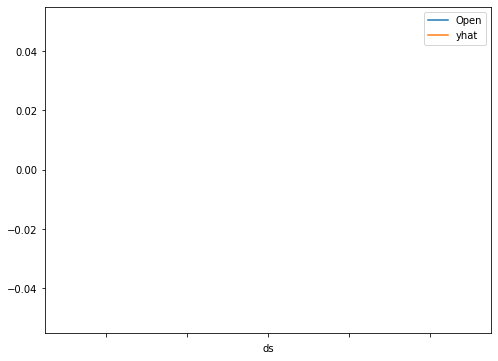

In [65]:
# df_close = pd.DataFrame(df_train['Open'])
# two_years = forecast.set_index('ds').join(df_train)
# two_years = two_years[['Open', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(200)
# two_years['yhat']=np.array(two_years.yhat)
# two_years['yhat_upper']=np.array(two_years.yhat_upper)
# two_years['yhat_lower']=np.array(two_years.yhat_lower)
# two_years[['Open', 'yhat']].plot(figsize=(8, 6));

In [52]:
#forecast = model_fbp.predict(df2[['Date', 'Open'] + features].rename(columns={'Date': 'ds'}))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



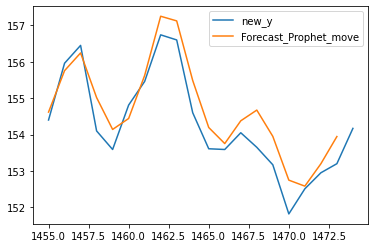

In [162]:
df_valid['new_y'] = df_valid['Open']
df_valid['Forecast_Prophet_move'] = df_valid['Forecast_Prophet'].shift(-1)
df_valid[['new_y', 'Forecast_Prophet_move']].plot()

In [147]:
# df_valid[['Date','Open','Forecast_Prophet','Forecast_Prophet_move']]

,Date,Open,Forecast_Prophet,Forecast_Prophet_move
1455,2019-01-28,154.40,153.832825,154.617615
1456,2019-01-29,155.96,154.617615,155.755892
1457,2019-01-30,156.45,155.755892,156.242648
1458,2019-01-31,154.10,156.242648,155.016255
1459,2019-02-01,153.59,155.016255,154.140843
1460,2019-02-02,154.81,154.140843,154.441830
1461,2019-02-03,155.46,154.441830,155.624570
1462,2019-02-04,156.74,155.624570,157.251024
1463,2019-02-05,156.60,157.251024,157.123019
1464,2019-02-06,154.60,157.123019,155.485520


In [101]:
# df_valid

,Open,High,Low,Close,Date,EMA_5,EMA_10,EMA_20,SMA_5,SMA_10,SMA_20,RSI,MACD,MACD_signal,y,Forecast_Prophet,new_y,Forecast_Prophet_move
1455,154.40,155.02,152.91,154.76,2019-01-28,151.856291,151.576028,150.905124,152.564,151.383,151.0790,69.152196,0.540497,0.162398,153.65,153.832825,154.40,154.617615
1456,155.96,156.80,155.07,156.46,2019-01-29,152.280243,151.832753,151.071546,153.054,152.050,151.0900,86.951983,0.800202,0.289959,154.40,154.617615,155.96,155.755892
1457,156.45,156.74,154.68,155.35,2019-01-30,152.893536,152.207957,151.304330,153.834,152.712,151.2170,96.498906,1.033644,0.438696,155.96,155.755892,156.45,156.242648
1458,154.10,156.22,154.09,154.10,2019-01-31,153.486280,152.593597,151.549362,154.654,153.293,151.4510,76.660839,1.017296,0.554416,156.45,156.242648,154.10,155.016255
1459,153.59,154.45,153.26,153.57,2019-02-01,153.588566,152.730543,151.670821,154.912,153.573,151.5875,75.085616,0.952211,0.633975,154.10,155.016255,153.59,154.140843
1460,154.81,155.03,153.55,154.81,2019-02-02,153.588805,152.808675,151.762210,154.900,153.732,151.6870,74.224978,0.987689,0.704718,153.59,154.140843,154.81,154.441830
1461,155.46,155.89,154.57,155.41,2019-02-03,153.792338,152.990614,151.907343,154.982,154.018,151.9310,72.650376,1.056081,0.774990,154.81,154.441830,155.46,155.624570
1462,156.74,157.85,155.16,156.74,2019-02-04,154.070281,153.215104,152.076517,154.882,154.358,152.1715,74.156306,1.199738,0.859940,155.46,155.624570,156.74,157.251024
1463,156.60,156.73,153.89,153.91,2019-02-05,154.515235,153.535549,152.298588,154.940,154.797,152.5645,71.495327,1.287449,0.945442,156.74,157.251024,156.60,157.123019
1464,154.60,155.11,153.70,154.00,2019-02-06,154.862695,153.814135,152.503417,155.440,155.176,152.9970,60.474308,1.181953,0.992744,156.60,157.123019,154.60,155.485520


In [ ]:
# df_valid['Forecast_Prophet'].head()

In [160]:
predict_price = df_valid['Forecast_Prophet_move'].tolist()
predict_price.insert(0,df_train['Open'][len(df_train)-1])
predict_price

[153.65,
 154.61761541049765,
 155.75589162921568,
 156.24264790915623,
 155.0162545216303,
 154.14084286360463,
 154.44182980091068,
 155.6245702761481,
 157.25102427823282,
 157.12301878724392,
 155.48551958123892,
 154.19413511255576,
 153.75253283326475,
 154.37833927338178,
 154.67273595593315,
 153.95042329425186,
 152.74813973336592,
 152.5831022456553,
 153.19749656659786,
 153.94587620246256,
 nan]

In [164]:
#一階
own = 0
answer = []
for i in range(1,len(predict_price)-1):
  if predict_price[i] - predict_price[i-1] > predict_price[i+1] - predict_price[i]:
    if own == 0:
      own -= 1
      answer.append(-1)
    elif own == 1:
      own -= 1
      answer.append(-1)
    elif own == -1:
      answer.append(0)
  if predict_price[i] - predict_price[i-1] < predict_price[i+1] - predict_price[i]:
    if own == 0:
      own += 1
      answer.append(1)
    elif own == 1:
      answer.append(0)
    elif own == -1:
      own += 1
      answer.append(1)
answer.append(0)
answer

[1, -1, -1, 1, 1, 0, 0, -1, -1, 1, 1, 0, -1, -1, 0, 1, 1, 0, 0]

In [161]:
# #相減
# own = 0
# answer = []
# for i in range(1,len(predict_price)-1):
#   if predict_price[i] < predict_price[i-1]:
#     if own == 0:
#       own -= 1
#       answer.append(-1)
#     elif own == 1:
#       own -= 1
#       answer.append(-1)
#     elif own == -1:
#       answer.append(0)
#   if predict_price[i] > predict_price[i-1]:
#     if own == 0:
#       own += 1
#       answer.append(1)
#     elif own == 1:
#       answer.append(0)
#     elif own == -1:
#       own += 1
#       answer.append(1)
# answer

[1, 0, 0, -1, -1, 1, 1, 0, -1, -1, 0, 0, 1, 1, -1, -1, 0, 1, 1]

In [77]:
# own = 0
# answer = []
# for i in range(len(predict_price)-2):
#   #print(predict_price[i])
#   if predict_price[i+1] > predict_price[i+2]:
#     if own == 0:
#       own -= 1
#       answer.append(-1)
#     elif own == 1:
#       own -= 1
#       answer.append(-1)
#     elif own == -1:
#       answer.append(0)
#   elif predict_price[i+1] < predict_price[i+2]:
#     if own == 0:
#       own += 1
#       answer.append(1)
#     elif own == 1:
#       answer.append(0)
#     elif own == -1:
#       own += 1
#       answer.append(1)
#   elif predict_price[i+1] == predict_price[i+2]:
#     answer.append(0)
#   #print(own)
# if own == 1:
#   own -= 1
#   answer.append(-1)
# elif own == -1:
#   own += 1
#   answer.append(1)
# answer.append(0)
# answer

[1, -1, -1, 1, 1, 0, -1, -1, 0, 0, 1, 1, -1, -1, 0, 1, 1, -1]

In [165]:
csv_file = open("/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/output.csv", "w")
for i in answer:
  csv_file.write(str(i)+'\n')
csv_file.close()

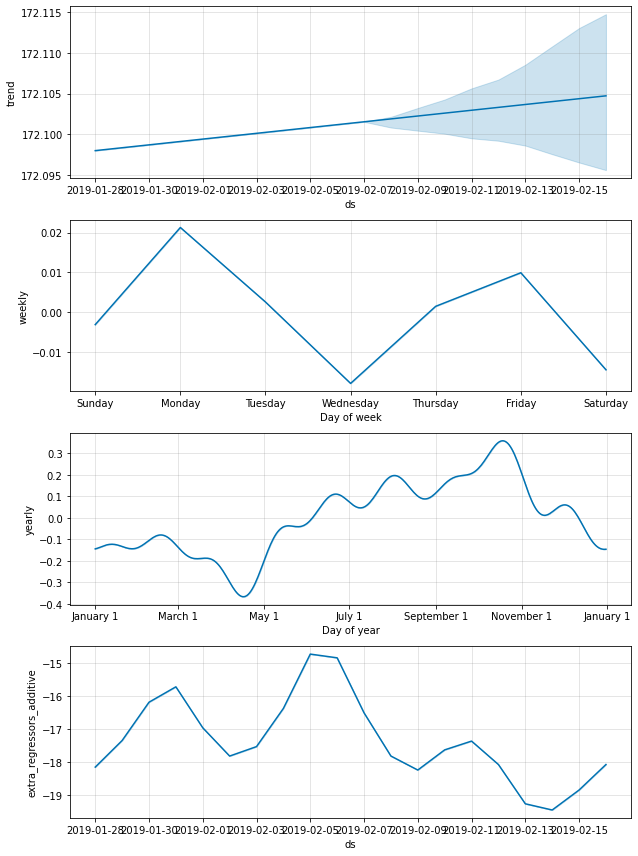

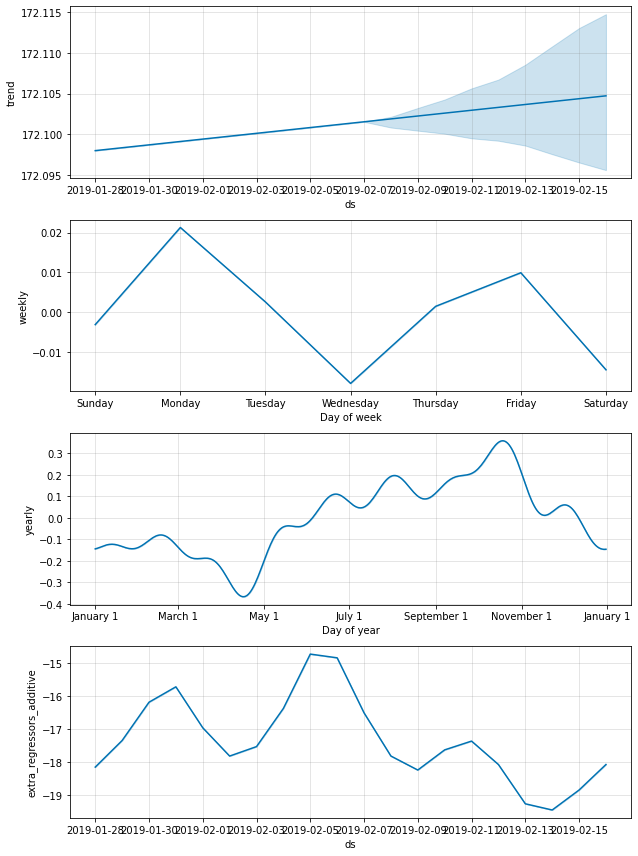

In [166]:
# model_fbp.plot_components(forecast)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.y, name='Close'))
# fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.Forecast_ARIMAX, name='Forecast_ARIMAX'))
# fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.Forecast_Prophet, name='Forecast_Prophet'))
# fig.show()

#print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.y, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.y, df_valid.Forecast_Prophet)))
#print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.y, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.y, df_valid.Forecast_Prophet))

In [ ]:
from pandas.core.frame import DataFrame
# You can write code above the if-main block.

import argparse
if __name__ == '__main__':
    # You should not modify this part.
    


    parser = argparse.ArgumentParser()
    parser.add_argument('--training',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/training_data.csv',help='input training data file name')
    parser.add_argument('--testing',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/testing_data.csv',help='input testing data file name')
    parser.add_argument('--output',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/output.csv',help='output file name')   
    args = parser.parse_args(args=[])


In [ ]:
# Load your cloud drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# -*- coding: utf-8 -*-

import sklearn
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet
import plotly.graph_objects as go
import argparse


# Load your cloud drive
from google.colab import drive
drive.mount('/content/drive')

def run(train,test,output):
      
  # 讀入series
  colnames=['Open','High','Low','Close'] 
  df_temp = pd.read_csv(train, names=colnames)
  date = pd.date_range(start='2015/01/01',periods=len(df_temp))
  df = df_temp
  date = pd.DataFrame(date)
  df[['Date']] = date
  #df.set_index('Date',inplace=True)
  price = df.squeeze()
  price.head()

  # 讀入series
  colnames=['Open','High','Low','Close'] 
  df_temp = pd.read_csv(test, names=colnames)
  date2 = pd.date_range(start=date.iloc[len(date)-1,0],periods=2)
  date2 = pd.DataFrame(date2)
  date2 = pd.date_range(start=date2.iloc[len(date2)-1,0],periods=len(df_temp))
  date2 = pd.DataFrame(date2)
  df2 = df_temp
  df2[['Date']] = date2
  #df2.set_index('Date',inplace=True)
  price2 = df2.squeeze()
  price2.head()

  # df = df[['Date', 'Open']]
  # df2 = df2[['Date', 'Open']]
  # df.columns = ['ds', 'y']
  # df2.columns = ['ds', 'y']
  # print(df)

  df = pd.concat([df,df2])
  df = df.reset_index()
  df = df[['Open','High','Low','Close','Date']]

  def relative_strength_idx(df, n=14):
      Open = df['Open']
      delta = Open.diff()
      delta = delta[1:]
      pricesUp = delta.copy()
      pricesDown = delta.copy()
      pricesUp[pricesUp < 0] = 0
      pricesDown[pricesDown > 0] = 0
      rollUp = pricesUp.rolling(n).mean()
      rollDown = pricesDown.abs().rolling(n).mean()
      rs = rollUp / rollDown
      rsi = 100.0 - (100.0 / (1.0 + rs))
      return rsi

  # SMA
  df['EMA_3'] = df['Open'].ewm(3).mean().shift()
  df['EMA_7'] = df['Open'].ewm(7).mean().shift()
  df['EMA_30'] = df['Open'].ewm(30).mean().shift()

  # EMA
  df['SMA_3'] = df['Open'].rolling(3).mean().shift()
  df['SMA_7'] = df['Open'].rolling(7).mean().shift()
  df['SMA_30'] = df['Open'].rolling(30).mean().shift()

  # RSI
  df['RSI'] = relative_strength_idx(df).fillna(0)

  # MACD
  EMA_12 = pd.Series(df['Open'].ewm(span=12, min_periods=12).mean())
  EMA_26 = pd.Series(df['Open'].ewm(span=26, min_periods=26).mean())
  df['MACD'] = pd.Series(EMA_12 - EMA_26)
  df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

  df['y'] = df['Open'].shift(-1)
  #print(df)
  df = df.dropna(axis=0).reset_index(drop=True)

  df_train = df.head(len(df)-len(df2)+1)
  df_valid = df.tail(len(df2)-1)

  # 畫圖看一下

  # fig = go.Figure()
  # fig.add_trace(go.Scatter(x=df_train.Date, y=df_train.Open, name='Training'))
  # fig.add_trace(go.Scatter(x=df_valid.Date, y=df_valid.Open, name='Validation'))
  # fig.show()

  features = ['SMA_3','SMA_7','SMA_30','EMA_3','EMA_7','EMA_30','RSI','MACD','MACD_signal']
  model_fbp = Prophet()
  for feature in features:
      model_fbp.add_regressor(feature)

  model_fbp.fit(df_train[['Date', 'Open'] + features].rename(columns={'Date': 'ds', 'Open': 'y'}))
  forecast = model_fbp.predict(df_valid[['Date', 'Open'] + features].rename(columns={'Date': 'ds'}))
  df_valid["Forecast_Prophet"] = forecast.yhat.values
  df_valid['Forecast_Prophet']

  df_valid['new_y'] = df_valid['y'].shift(1)
  df_valid[['new_y', 'Forecast_Prophet']].plot()

  predict_price = df_valid['Forecast_Prophet'].tolist()

  own = 0
  answer = []
  for i in range(len(predict_price)-2):
    #print(predict_price[i])
    if predict_price[i+1] > predict_price[i+2]:
      if own == 0:
        own -= 1
        answer.append(-1)
      elif own == 1:
        own -= 1
        answer.append(-1)
      elif own == -1:
        answer.append(0)
    elif predict_price[i+1] < predict_price[i+2]:
      if own == 0:
        own += 1
        answer.append(1)
      elif own == 1:
        answer.append(0)
      elif own == -1:
        own += 1
        answer.append(1)
    elif predict_price[i+1] == predict_price[i+2]:
      answer.append(0)
    #print(own)
  if own == 1:
    own -= 1
    answer.append(-1)
  elif own == -1:
    own += 1
    answer.append(1)
  answer.append(0)
  print(answer)
  csv_file = open(output, "w")
  for i in answer:
    csv_file.write(str(i)+'\n')
  csv_file.close()

  #model_fbp.plot_components(forecast)


  #print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.y, df_valid.Forecast_ARIMAX)))
  print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.y, df_valid.Forecast_Prophet)))
  #print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.y, df_valid.Forecast_ARIMAX))
  print("MAE of Prophet:", mean_absolute_error(df_valid.y, df_valid.Forecast_Prophet))

  # You can write code above the if-main block.

if __name__ == '__main__':
    # You should not modify this part.
    


    parser = argparse.ArgumentParser()
    parser.add_argument('--training',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/training.csv',help='input training data file name')
    parser.add_argument('--testing',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/testing.csv',help='input testing data file name')
    parser.add_argument('--output',default='/content/drive/MyDrive/Colab Notebooks/data_mining/hw2/output.csv',help='output file name')   
    args = parser.parse_args(args=[])

    run(args.training, args.testing, args.output)

In [ ]:
!pip freeze > requirements.txt